In [1]:
import os
import sys

notebook_path = os.path.abspath(".")
project_root = os.path.abspath(os.path.join(notebook_path, ".."))
os.chdir(project_root)

sys.path.append(os.path.join(project_root, "src"))

print(f"Current working directory: {project_root}")

%env WANDB_SILENT=true

Current working directory: /home/arian/deepLearning/del
env: WANDB_SILENT=true


In [2]:
import random
import shutil
import pickle
from glob import glob
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

from tqdm import tqdm
from tqdm.notebook import tqdm as notebook_tqdm

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy

import wandb

from src.utils import plot_training_curves

from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset
import numpy as np
import pickle
import os
import hashlib

# Image resizing test

## Dataset

Since there isn't any direct description what the dataset contains, which I downloaded here [Kaggle](https://www.kaggle.com/datasets/liusha249/imagenet10), I will first try to get an overview about my dataset.

In [3]:
data_dir = os.path.join(project_root, "data", "original")

class_names = sorted(os.listdir(data_dir))
print(f"Count of classes: {len(class_names)}")
print(f"Example class names: {class_names}")

Count of classes: 10
Example class names: ['Airliner', 'Airship', 'Container ship', 'King Penguin', 'Maltese dog', 'Orange (fruit)', 'Snow Leopard', 'Soccer ball', 'Sports car', 'Trailer truck']


### What do the class names present?

Those `n02056570` are so called `WNDIs` which are WordNet IDs - unique identifiers used by ImageNet to represent a specific synset (i.e., a group of synonymous words/meanings). Those aren't at all not human-readable, even if they map to actual objects.

To make training in the future easier, I will map these IDs to human-readable labels:

In [4]:
wnid_to_label = {
    "n02056570": "King Penguin",
    "n02085936": "Maltese dog",
    "n02128757": "Snow Leopard",
    "n02690373": "Airliner",
    "n02692877": "Airship",
    "n03095699": "Container ship",
    "n04254680": "Soccer ball",
    "n04285008": "Sports car",
    "n04467665": "Trailer truck",
    "n07747607": "Orange (fruit)"
}

In [5]:
# TODO: REMOVE THIS LATER
for wnid, label in wnid_to_label.items():
    label_path = os.path.join(data_dir, label)
    wnid_path = os.path.join(data_dir, wnid)
    if os.path.exists(label_path) and not os.path.exists(wnid_path):
        os.rename(label_path, wnid_path)

# Update class_names after renaming back
class_names = sorted(os.listdir(data_dir))
print(f"Renamed class folders back to WNIDs. New class names: {class_names}")

Renamed class folders back to WNIDs. New class names: ['n02056570', 'n02085936', 'n02128757', 'n02690373', 'n02692877', 'n03095699', 'n04254680', 'n04285008', 'n04467665', 'n07747607']


In [6]:
# Rename folders in data_dir from WNID to human-readable label
for wnid, label in wnid_to_label.items():
    old_path = os.path.join(data_dir, wnid)
    new_path = os.path.join(data_dir, label)
    if os.path.exists(old_path) and not os.path.exists(new_path):
        os.rename(old_path, new_path)

# Update class_names after renaming
class_names = sorted(os.listdir(data_dir))
print(f"Renamed class folders. New class names: {class_names}")


Renamed class folders. New class names: ['Airliner', 'Airship', 'Container ship', 'King Penguin', 'Maltese dog', 'Orange (fruit)', 'Snow Leopard', 'Soccer ball', 'Sports car', 'Trailer truck']


Let's dive deeper into the dataset. Now we will see how many images there are and how many per class.

In [7]:
image_counts = {}
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    num_images = len(os.listdir(class_path))
    image_counts[class_name] = num_images

print("Number of images per class:")
total_images = 0
for class_name, count in image_counts.items():
    print(f"{class_name}: {count}")
    total_images += count
print(f"Total number of images: {total_images}")

Number of images per class:
Airliner: 1300
Airship: 1300
Container ship: 1300
King Penguin: 1300
Maltese dog: 1300
Orange (fruit): 1300
Snow Leopard: 1300
Soccer ball: 1300
Sports car: 1300
Trailer truck: 1300
Total number of images: 13000


## Splitting


In [8]:
original_dir = os.path.join(project_root, "data", "original")
split_base_dir = os.path.join(project_root, "data", "split_data")

train_dir = os.path.join(split_base_dir, "train")
val_dir = os.path.join(split_base_dir, "val")
test_dir = os.path.join(split_base_dir, "test")

# Delete target directories and recreate them
for d in [train_dir, val_dir, test_dir]:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d)

# Split-Ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

class_names = sorted(os.listdir(original_dir))

for class_name in class_names:
    img_dir = os.path.join(original_dir, class_name)
    all_images = glob(os.path.join(img_dir, "*.JPEG"))
    print(f"Class '{class_name}' has {len(all_images)} images before split.")

    train_imgs, temp_imgs = train_test_split(all_images, train_size=train_ratio, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)  # each 10%

    print(f"  Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

    for split, img_list in zip(
        [train_dir, val_dir, test_dir],
        [train_imgs, val_imgs, test_imgs]
    ):
        target_class_dir = os.path.join(split, class_name)
        os.makedirs(target_class_dir, exist_ok=True)
        for img in img_list:
            shutil.copy(img, os.path.join(target_class_dir, os.path.basename(img)))

print("Train/Val/Test split completed.")

Class 'Airliner' has 1300 images before split.
  Train: 1040, Val: 130, Test: 130
Class 'Airship' has 1300 images before split.
  Train: 1040, Val: 130, Test: 130
Class 'Container ship' has 1300 images before split.
  Train: 1040, Val: 130, Test: 130
Class 'King Penguin' has 1300 images before split.
  Train: 1040, Val: 130, Test: 130
Class 'Maltese dog' has 1300 images before split.
  Train: 1040, Val: 130, Test: 130
Class 'Orange (fruit)' has 1300 images before split.
  Train: 1040, Val: 130, Test: 130
Class 'Snow Leopard' has 1300 images before split.
  Train: 1040, Val: 130, Test: 130
Class 'Soccer ball' has 1300 images before split.
  Train: 1040, Val: 130, Test: 130
Class 'Sports car' has 1300 images before split.
  Train: 1040, Val: 130, Test: 130
Class 'Trailer truck' has 1300 images before split.
  Train: 1040, Val: 130, Test: 130
Train/Val/Test split completed.


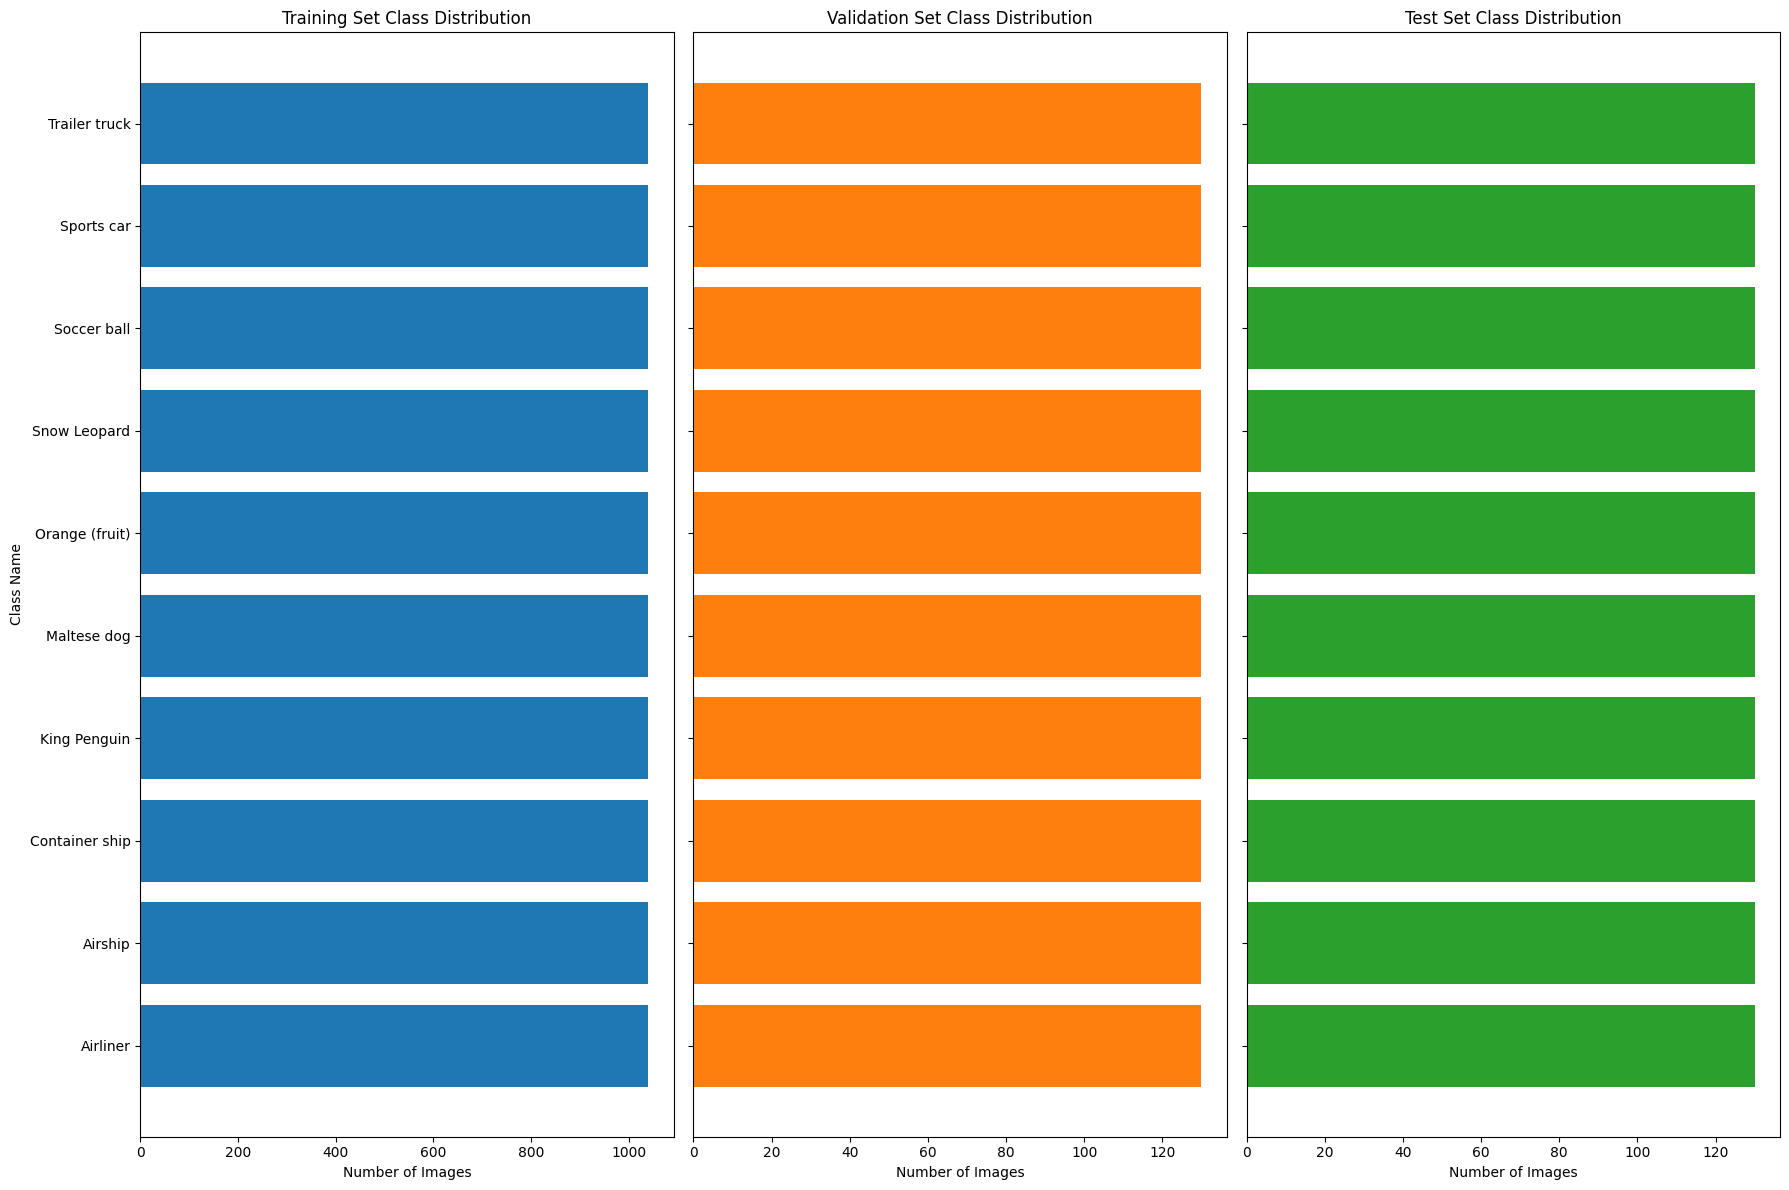

In [9]:
# Count images per class in each split
def count_images_per_class(split_dir):
    class_counts = {}
    for class_name in sorted(os.listdir(split_dir)):
        class_path = os.path.join(split_dir, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.endswith('.JPEG')])
            class_counts[class_name] = count
    return class_counts

train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(val_dir)
test_counts = count_images_per_class(test_dir)

# Plotting with class names on the y-axis (horizontal bar plots)
fig, axs = plt.subplots(1, 3, figsize=(18, 12), sharey=True)

axs[0].barh(list(train_counts.keys()), list(train_counts.values()), color='tab:blue')
axs[0].set_title('Training Set Class Distribution')
axs[0].set_xlabel('Number of Images')
axs[0].set_ylabel('Class Name')

axs[1].barh(list(val_counts.keys()), list(val_counts.values()), color='tab:orange')
axs[1].set_title('Validation Set Class Distribution')
axs[1].set_xlabel('Number of Images')
# axs[1].set_ylabel('Class Name')  # Only set on first plot

axs[2].barh(list(test_counts.keys()), list(test_counts.values()), color='tab:green')
axs[2].set_title('Test Set Class Distribution')
axs[2].set_xlabel('Number of Images')
# axs[2].set_ylabel('Class Name')  # Only set on first plot

plt.tight_layout()
plt.show()


The class distribution across the training, validation, and test datasets is uniform, with each class containing an equal number of samples. This balanced distribution ensures that the model is trained and evaluated on an equal representation of all classes, reducing the risk of bias toward any specific class and supporting fair performance evaluation.

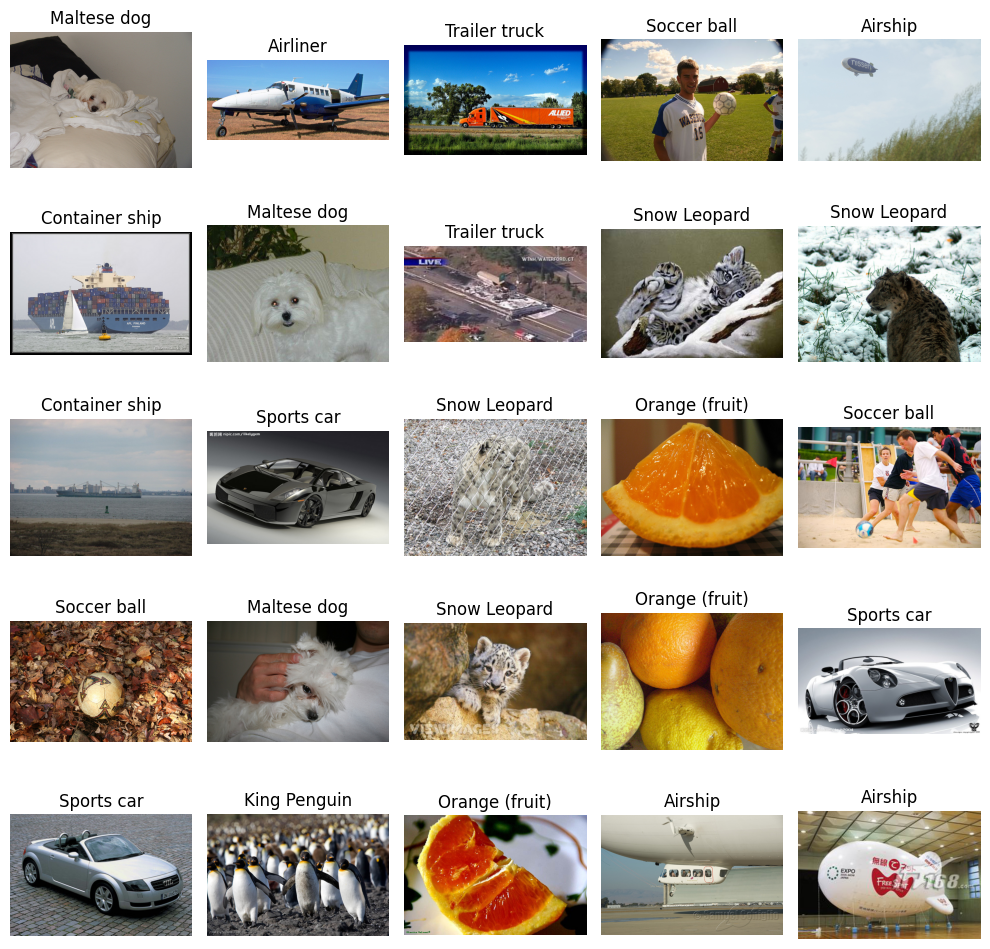

In [10]:
# Display 25 sample images from the training set
import random

# Get all image file paths and their corresponding class labels
train_image_paths = []
train_image_labels = []
for class_name in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.endswith('.JPEG'):
                train_image_paths.append(os.path.join(class_path, fname))
                train_image_labels.append(class_name)

# Randomly select 25 images
sample_indices = random.sample(range(len(train_image_paths)), 25)

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
axs = axs.flatten()
for i, idx in enumerate(sample_indices):
    img = Image.open(train_image_paths[idx])
    axs[i].imshow(img)
    axs[i].set_title(train_image_labels[idx])
    axs[i].axis('off')

fig.tight_layout()
plt.show()

Let's check now the image sizes of the dataset.

In [11]:
image_shapes = []

for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.endswith('.JPEG'):
            img_path = os.path.join(root, file)
            try:
                with Image.open(img_path) as img:
                    image_shapes.append(img.size)  # (width, height)
            except:
                print("Could not open:", img_path)

# Count how often each shape appears
shape_counts = Counter(image_shapes)

print("Most common image shapes (width x height):")
for shape, count in shape_counts.most_common(10):
    print(f"{shape[0]}x{shape[1]}: {count} images")

# Optional: min and max sizes
widths, heights = zip(*image_shapes)
print("\nWidth range:", min(widths), "to", max(widths))
print("Height range:", min(heights), "to", max(heights))

Most common image shapes (width x height):
500x375: 2528 images
500x333: 1309 images
375x500: 462 images
500x334: 326 images
333x500: 254 images
500x332: 251 images
500x500: 90 images
500x335: 90 images
640x480: 72 images
500x374: 72 images

Width range: 62 to 4992
Height range: 50 to 3328


As we can see we have a variaty of image shapes going from lowest width from `62` to `4992` and height from `50` to `3328`. We will need to be aware of these shapes, cause most CNNs require fixed-size inputs. We will tackle the resizing later but lastly we will check the distribution of RGB channels.

In [12]:
train_dir = os.path.join(project_root, "data", "split_data", "train")

# Accumulators
channel_sum = np.zeros(3)
channel_squared_sum = np.zeros(3)
num_pixels = 0

for class_name in tqdm(sorted(os.listdir(train_dir)), desc="Processing"):
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith('.JPEG')]

    for file in image_files:
        img_path = os.path.join(class_path, file)
        with Image.open(img_path) as img:
            img = img.convert("RGB")
            img_array = np.array(img) / 255.0  # Normalize to [0,1]

            # Reshape to (-1, 3) so each row is a pixel
            pixels = img_array.reshape(-1, 3)

            channel_sum += pixels.sum(axis=0)
            channel_squared_sum += (pixels ** 2).sum(axis=0)
            num_pixels += pixels.shape[0]

# Mean and std
channel_mean = channel_sum / num_pixels
channel_std = np.sqrt(channel_squared_sum / num_pixels - channel_mean ** 2)

print("RGB Channel Means :", channel_mean)
print("RGB Channel Stds  :", channel_std)

Processing: 100%|██████████| 10/10 [00:57<00:00,  5.73s/it]

RGB Channel Means : [0.48618012 0.47722418 0.45128954]
RGB Channel Stds  : [0.27312508 0.26390328 0.29191818]


We will need these RGB Channel Means and Standard Deviations later to normalize the dataset to ensure that the color channels values are standardized across the dataset.

Processing: 100%|██████████| 10/10 [00:27<00:00,  2.70s/it]


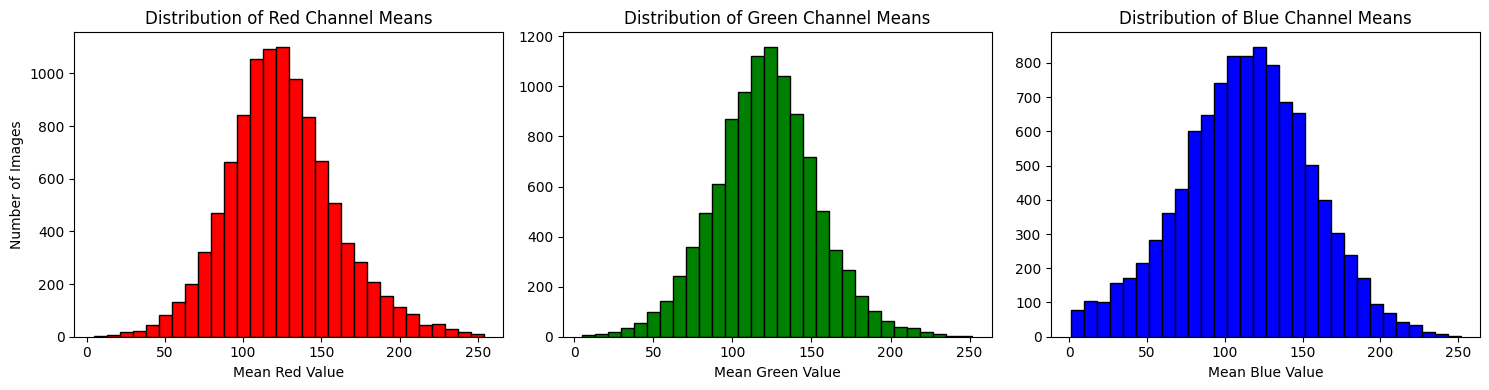

In [13]:
train_dir = os.path.join(project_root, "data", "split_data", "train")

red_means = []
green_means = []
blue_means = []

for class_name in tqdm(sorted(os.listdir(train_dir)), desc="Processing"):
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith('.JPEG')]

    for file in image_files:
        img_path = os.path.join(class_path, file)
        with Image.open(img_path) as img:
            img = img.convert("RGB")
            img_array = np.array(img)

            red_means.append(np.mean(img_array[:, :, 0]))
            green_means.append(np.mean(img_array[:, :, 1]))
            blue_means.append(np.mean(img_array[:, :, 2]))

# Plotting
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(red_means, bins=30, color='red', edgecolor='black')
plt.title("Distribution of Red Channel Means")
plt.xlabel("Mean Red Value")
plt.ylabel("Number of Images")

plt.subplot(1, 3, 2)
plt.hist(green_means, bins=30, color='green', edgecolor='black')
plt.title("Distribution of Green Channel Means")
plt.xlabel("Mean Green Value")

plt.subplot(1, 3, 3)
plt.hist(blue_means, bins=30, color='blue', edgecolor='black')
plt.title("Distribution of Blue Channel Means")
plt.xlabel("Mean Blue Value")

plt.tight_layout()
plt.show()

---

## Image resizing test

### Why These Image Transformations?

To train a deep learning model, all input images must have the same size. This script:

- Loads and displays original images.
- Compares two resizing strategies:
  - `Resize((224, 224))`: Stretches images, may distort aspect ratio.
  - `Resize(224) + CenterCrop(224)`: Keeps aspect ratio, crops center.
- Visualizes effects to help choose the best preprocessing.
- Prepares a `DataLoader` with the selected transform for model training.

Ensures consistent, model-ready input without unexpected distortions.

In [14]:
image_size = 224
custom_mean = channel_mean
custom_std = channel_std

# 1. Standard Resize (stretches)
resize_base = transforms.Resize((image_size, image_size))

# 2. Proportional Resize + CenterCrop
center_crop_base = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size)
])

In [15]:
train_transforms_resize = transforms.Compose([
    resize_base,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=custom_mean, std=custom_std)
])

train_transforms_center_crop = transforms.Compose([
    center_crop_base,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=custom_mean, std=custom_std)
])

# VAL/TEST TRANSFORMS
val_test_transforms_resize = transforms.Compose([
    resize_base,
    transforms.ToTensor(),
    transforms.Normalize(mean=custom_mean, std=custom_std)
])

val_test_transforms_center_crop = transforms.Compose([
    center_crop_base,
    transforms.ToTensor(),
    transforms.Normalize(mean=custom_mean, std=custom_std)
])

In [16]:
# Resize-based datasets
train_dataset_resize = ImageFolder(root=train_dir, transform=train_transforms_resize)
val_dataset_resize = ImageFolder(root=val_dir, transform=val_test_transforms_resize)
test_dataset_resize = ImageFolder(root=test_dir, transform=val_test_transforms_resize)

# Center-crop-based datasets
train_dataset_center_crop = ImageFolder(root=train_dir, transform=train_transforms_center_crop)
val_dataset_center_crop = ImageFolder(root=val_dir, transform=val_test_transforms_center_crop)
test_dataset_center_crop = ImageFolder(root=test_dir, transform=val_test_transforms_center_crop)

print(f"Resize-based Train: {len(train_dataset_resize)}, Val: {len(val_dataset_resize)}, Test: {len(test_dataset_resize)}")
print(f"Center-crop-based Train: {len(train_dataset_center_crop)}, Val: {len(val_dataset_center_crop)}, Test: {len(test_dataset_center_crop)}")

Resize-based Train: 10400, Val: 1300, Test: 1300
Center-crop-based Train: 10400, Val: 1300, Test: 1300


In [17]:
batch_size = 64
num_workers = 4

# Resize-based loaders
train_loader_resize = DataLoader(train_dataset_resize, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader_resize = DataLoader(val_dataset_resize, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader_resize = DataLoader(test_dataset_resize, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Center-crop-based loaders
train_loader_center_crop = DataLoader(train_dataset_center_crop, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader_center_crop = DataLoader(val_dataset_center_crop, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader_center_crop = DataLoader(test_dataset_center_crop, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## Baseline model for resizing test

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Baseline CNN Modell

In [20]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Eingangsgröße nach 3x Pooling bei 224x224 Input: 28x28
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

### Modellinitialisierung, Loss, Optimizer

In [21]:
num_classes_resize = len(train_dataset_resize.classes)
num_classes_center_crop = len(train_dataset_center_crop.classes)

model_resize = SimpleCNN(num_classes=num_classes_resize).to(device)
model_center_crop = SimpleCNN(num_classes=num_classes_center_crop).to(device)

criterion_resize = nn.CrossEntropyLoss()
optimizer_resize = optim.SGD(model_resize.parameters(), lr=0.01)

criterion_center_crop = nn.CrossEntropyLoss()
optimizer_center_crop = optim.SGD(model_center_crop.parameters(), lr=0.01)

In [22]:
from src.utils import get_number_of_parameters

print(f"Number of parameters (Resize): {get_number_of_parameters(model_resize)}")
print(f"Number of parameters (Center Crop): {get_number_of_parameters(model_center_crop)}")

Number of parameters (Resize): 12939722
Number of parameters (Center Crop): 12939722


### W&B initializing

In [23]:
import wandb

wandb_resize = wandb.init(
    project="del-main-mc2",
    name="SimpleCNN_resize",
    settings=wandb.Settings(silent=True),
    config={
        "architecture": "SimpleCNN",
        "epochs": 20,
        "batch_size": 32,
        "optimizer": "SGD",
        "learning_rate": 0.01,
        "loss": "CrossEntropyLoss",
        "dataset": "custom_split_data_resize",
        "image_size": 224,
        "preprocessing": "resize",
        "num_parameters": get_number_of_parameters(model_resize)
    },
    reinit=True
)

wandb_center_crop = wandb.init(
    project="del-main-mc2",
    name="SimpleCNN_center_crop",
    settings=wandb.Settings(silent=True),
    config={
        "architecture": "SimpleCNN",
        "epochs": 20,
        "batch_size": 32,
        "optimizer": "SGD",
        "learning_rate": 0.01,
        "loss": "CrossEntropyLoss",
        "dataset": "custom_split_data_center_crop",
        "image_size": 224,
        "preprocessing": "center_crop",
        "num_parameters": get_number_of_parameters(model_center_crop)
    },
    reinit=True
)

### Trainingsloop

In [24]:
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

### Validierungsloop

In [25]:
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return running_loss / total, correct / total

### Training

In [26]:
from tqdm.notebook import trange
import os
import pickle
import hashlib

def get_model_hash(model, config):
    # Serialize model architecture and config for hashing
    model_str = str(model)
    config_str = str(config)
    hash_input = (model_str + config_str).encode('utf-8')
    return hashlib.md5(hash_input).hexdigest()

# Directory to store cached results
cache_dir = project_root + "/training_cache"
os.makedirs(cache_dir, exist_ok=True)

# --- model ---
model_test_resize = SimpleCNN(num_classes=num_classes_resize).to(device)
criterion_test_resize = nn.CrossEntropyLoss()
optimizer_test_resize = optim.SGD(model_test_resize.parameters(), lr=0.01)

model_hash_resize = get_model_hash(model_test_resize, wandb.config)
cache_path_resize = os.path.join(cache_dir, f"{model_hash_resize}_resize.pkl")

if os.path.exists(cache_path_resize):
    with open(cache_path_resize, "rb") as f:
        cached = pickle.load(f)
    train_losses_resize = cached["train_losses"]
    val_losses_resize = cached["val_losses"]
    train_accs_resize = cached["train_accs"]
    val_accs_resize = cached["val_accs"]
    print("Loaded cached training results for resize model/config.")
    for epoch, (train_loss, train_acc, val_loss, val_acc) in enumerate(zip(train_losses_resize, train_accs_resize, val_losses_resize, val_accs_resize)):
        wandb.log({
            "epoch_resize": epoch + 1,
            "train_loss_resize": train_loss,
            "train_acc_resize": train_acc,
            "val_loss_resize": val_loss,
            "val_acc_resize": val_acc
        })
else:
    num_epochs_resize = wandb.config.epochs
    train_losses_resize, val_losses_resize = [], []
    train_accs_resize, val_accs_resize = [], []

    for epoch in trange(num_epochs_resize, desc="Epochs (resize)"):
        train_loss, train_acc = train(model_test_resize, train_loader_resize, optimizer_test_resize, criterion_test_resize)
        val_loss, val_acc = evaluate(model_test_resize, val_loader_resize, criterion_test_resize)

        train_losses_resize.append(train_loss)
        val_losses_resize.append(val_loss)
        train_accs_resize.append(train_acc)
        val_accs_resize.append(val_acc)

        print(f"[Resize] Epoch {epoch+1}/{num_epochs_resize} "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        wandb.log({
            "epoch_resize": epoch + 1,
            "train_loss_resize": train_loss,
            "train_acc_resize": train_acc,
            "val_loss_resize": val_loss,
            "val_acc_resize": val_acc
        })
    with open(cache_path_resize, "wb") as f:
        pickle.dump({
            "train_losses": train_losses_resize,
            "val_losses": val_losses_resize,
            "train_accs": train_accs_resize,
            "val_accs": val_accs_resize
        }, f)

# --- center crop model ---
model_test_center_crop = SimpleCNN(num_classes=num_classes_center_crop).to(device)
criterion_test_center_crop = nn.CrossEntropyLoss()
optimizer_test_center_crop = optim.SGD(model_test_center_crop.parameters(), lr=0.01)

model_hash_center_crop = get_model_hash(model_test_center_crop, wandb.config)
cache_path_center_crop = os.path.join(cache_dir, f"{model_hash_center_crop}_centercrop.pkl")

if os.path.exists(cache_path_center_crop):
    with open(cache_path_center_crop, "rb") as f:
        cached = pickle.load(f)
    train_losses_center_crop = cached["train_losses"]
    val_losses_center_crop = cached["val_losses"]
    train_accs_center_crop = cached["train_accs"]
    val_accs_center_crop = cached["val_accs"]
    print("Loaded cached training results for center crop model/config.")
    for epoch, (train_loss, train_acc, val_loss, val_acc) in enumerate(zip(train_losses_center_crop, train_accs_center_crop, val_losses_center_crop, val_accs_center_crop)):
        wandb.log({
            "epoch_center_crop": epoch + 1,
            "train_loss_center_crop": train_loss,
            "train_acc_center_crop": train_acc,
            "val_loss_center_crop": val_loss,
            "val_acc_center_crop": val_acc
        })
else:
    num_epochs_center_crop = wandb.config.epochs
    train_losses_center_crop, val_losses_center_crop = [], []
    train_accs_center_crop, val_accs_center_crop = [], []

    for epoch in trange(num_epochs_center_crop, desc="Epochs (center crop)"):
        train_loss, train_acc = train(model_test_center_crop, train_loader_center_crop, optimizer_test_center_crop, criterion_test_center_crop)
        val_loss, val_acc = evaluate(model_test_center_crop, val_loader_center_crop, criterion_test_center_crop)

        train_losses_center_crop.append(train_loss)
        val_losses_center_crop.append(val_loss)
        train_accs_center_crop.append(train_acc)
        val_accs_center_crop.append(val_acc)

        print(f"[Center Crop] Epoch {epoch+1}/{num_epochs_center_crop} "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        wandb.log({
            "epoch_center_crop": epoch + 1,
            "train_loss_center_crop": train_loss,
            "train_acc_center_crop": train_acc,
            "val_loss_center_crop": val_loss,
            "val_acc_center_crop": val_acc
        })
    with open(cache_path_center_crop, "wb") as f:
        pickle.dump({
            "train_losses": train_losses_center_crop,
            "val_losses": val_losses_center_crop,
            "train_accs": train_accs_center_crop,
            "val_accs": val_accs_center_crop
        }, f)

Epochs (resize):   0%|          | 0/20 [00:00<?, ?it/s]

[Resize] Epoch 1/20 Train Loss: 1.9192, Acc: 0.3052 | Val Loss: 1.7440, Acc: 0.3862
[Resize] Epoch 2/20 Train Loss: 1.5973, Acc: 0.4346 | Val Loss: 1.5010, Acc: 0.4754
[Resize] Epoch 3/20 Train Loss: 1.4494, Acc: 0.5051 | Val Loss: 1.3304, Acc: 0.5654
[Resize] Epoch 4/20 Train Loss: 1.3527, Acc: 0.5431 | Val Loss: 1.3277, Acc: 0.5523
[Resize] Epoch 5/20 Train Loss: 1.2677, Acc: 0.5741 | Val Loss: 1.3252, Acc: 0.5369
[Resize] Epoch 6/20 Train Loss: 1.2126, Acc: 0.5973 | Val Loss: 1.2845, Acc: 0.5615
[Resize] Epoch 7/20 Train Loss: 1.1543, Acc: 0.6206 | Val Loss: 1.1809, Acc: 0.6069
[Resize] Epoch 8/20 Train Loss: 1.1083, Acc: 0.6327 | Val Loss: 1.1373, Acc: 0.5962
[Resize] Epoch 9/20 Train Loss: 1.0549, Acc: 0.6485 | Val Loss: 1.0205, Acc: 0.6638
[Resize] Epoch 10/20 Train Loss: 1.0069, Acc: 0.6673 | Val Loss: 1.0557, Acc: 0.6392
[Resize] Epoch 11/20 Train Loss: 0.9671, Acc: 0.6792 | Val Loss: 0.9783, Acc: 0.6769
[Resize] Epoch 12/20 Train Loss: 0.9242, Acc: 0.6901 | Val Loss: 0.9614, A

Epochs (center crop):   0%|          | 0/20 [00:00<?, ?it/s]

[Center Crop] Epoch 1/20 Train Loss: 1.9272, Acc: 0.3058 | Val Loss: 1.7058, Acc: 0.4069
[Center Crop] Epoch 2/20 Train Loss: 1.6058, Acc: 0.4354 | Val Loss: 1.5045, Acc: 0.4877
[Center Crop] Epoch 3/20 Train Loss: 1.4600, Acc: 0.4960 | Val Loss: 1.4464, Acc: 0.5131
[Center Crop] Epoch 4/20 Train Loss: 1.3746, Acc: 0.5311 | Val Loss: 1.4122, Acc: 0.5323
[Center Crop] Epoch 5/20 Train Loss: 1.2999, Acc: 0.5672 | Val Loss: 1.2864, Acc: 0.5908
[Center Crop] Epoch 6/20 Train Loss: 1.2325, Acc: 0.5868 | Val Loss: 1.3716, Acc: 0.5246
[Center Crop] Epoch 7/20 Train Loss: 1.1775, Acc: 0.6062 | Val Loss: 1.2131, Acc: 0.5885
[Center Crop] Epoch 8/20 Train Loss: 1.1258, Acc: 0.6205 | Val Loss: 1.1841, Acc: 0.6069
[Center Crop] Epoch 9/20 Train Loss: 1.0701, Acc: 0.6451 | Val Loss: 1.0713, Acc: 0.6523
[Center Crop] Epoch 10/20 Train Loss: 1.0198, Acc: 0.6601 | Val Loss: 1.1405, Acc: 0.6000
[Center Crop] Epoch 11/20 Train Loss: 0.9735, Acc: 0.6781 | Val Loss: 1.1023, Acc: 0.6223
[Center Crop] Epoch

### Test-Set evaluation and logging

In [ ]:
# Evaluate and log for resize model
test_loss_resize, test_acc_resize = evaluate(model_test_resize, test_loader_resize, criterion_test_resize)
print(f"[Resize] Test Loss: {test_loss_resize:.4f}, Test Accuracy: {test_acc_resize:.4f}")

wandb.log({
    "test_loss_resize": test_loss_resize,
    "test_acc_resize": test_acc_resize
})

# Evaluate and log for center crop model
test_loss_center_crop, test_acc_center_crop = evaluate(model_test_center_crop, test_loader_center_crop, criterion_test_center_crop)
print(f"[Center Crop] Test Loss: {test_loss_center_crop:.4f}, Test Accuracy: {test_acc_center_crop:.4f}")

wandb.log({
    "test_loss_center_crop": test_loss_center_crop,
    "test_acc_center_crop": test_acc_center_crop
})

wandb.finish()

In [ ]:
plot_training_curves(train_losses_resize, val_losses_resize, train_accs_resize, val_accs_resize, run_number=1, model_name="SimpleCNN (Resize)", learning_rate=0.01, batch_size=64)

In [ ]:

plot_training_curves(train_losses_center_crop, val_losses_center_crop, train_accs_center_crop, val_accs_center_crop, run_number=1, model_name="SimpleCNN (Center Crop)", learning_rate=0.01, batch_size=64)

## Train overview

**CNN with resize method** 
- Val accuracy increases steadily and reaches about 0.72 towards the end
- Train accuracy increases continuously without strong overfitting
- Validation loss remains relatively stable after Epoch 10 and decreases slightly

**CNN with center crop method**
- Val Accuracy is similar, but somewhat more inconsistent - more fluctuations.
- When looking at Validation Accuracy and Validation Loss at the same time, the training appears somewhat more unstable.
- Train Accuracy is almost identical, but the validation result is not quite as constant as with Resize.

### Test results

**Resize: Test accuracy = 8.69%**

**Center Crop: Test accuracy = 9.92%**

Both models have a very low test accuracy (both under 10%) which indicates that the models aren't trained well, but that will be problem for later. For now we will use the `center_crop` method for the future tweaking of the model because of these results:

- **Image distortion:** The simple resize method (stretching) distorts the images, which can lead to unnatural proportions. This can be particularly problematic if your original images have very different aspect ratios (e.g. 500x375 vs 375x500).

- **Loss of information:** Center Crop retains the original proportions of the images and only cuts off the edges. This is often better than distorting the entire image.

- **Consistency:** Center Crop creates more consistent image sections because it always uses the central part of the image, which often contains the most important visual information.

We will also check with Crossvalidation those claims in the next section.

### Crossfold validation

In [29]:
def _make_cv_cache_name(model_class, dataset, num_classes, k, epochs, batch_size, lr):
    """
    Create a unique cache filename for cross-validation results, using as much dataset-specific
    information as possible. This version hashes the indices of the first 100 samples and the class
    distribution, so that different datasets (even with the same root) get different cache files.
    """
    # Try to get a unique identifier for the dataset
    dataset_id_parts = []

    # Use root path if available
    if hasattr(dataset, 'root'):
        dataset_id_parts.append(str(dataset.root))
    # Use transforms if available (to distinguish resize/crop)
    if hasattr(dataset, 'transform') and dataset.transform is not None:
        dataset_id_parts.append(str(dataset.transform))
    # Use class names if available
    if hasattr(dataset, 'classes'):
        dataset_id_parts.append(str(dataset.classes))
    # Use targets if available (for class distribution)
    if hasattr(dataset, 'targets'):
        targets = dataset.targets
        if isinstance(targets, list):
            targets_arr = np.array(targets)
        else:
            targets_arr = np.array(targets)
        class_hist = np.bincount(targets_arr) if len(targets_arr) > 0 else []
        dataset_id_parts.append("hist" + str(class_hist.tolist()))
        # Hash the first 100 indices to distinguish different splits
        first_100 = targets_arr[:100]
        dataset_id_parts.append("first100_" + hashlib.md5(first_100.tobytes()).hexdigest())
    else:
        # Fallback: use length
        dataset_id_parts.append("len" + str(len(dataset)))

    dataset_id = "_".join(dataset_id_parts)

    # Model class name
    model_name = model_class.__name__
    # Compose a string with all params
    cache_str = f"{model_name}_{dataset_id}_nc{num_classes}_k{k}_ep{epochs}_bs{batch_size}_lr{lr}"
    # Hash to avoid long filenames
    cache_hash = hashlib.md5(cache_str.encode()).hexdigest()
    cache_dir = "./cv_cache"
    os.makedirs(cache_dir, exist_ok=True)
    cache_path = os.path.join(cache_dir, f"cv_{cache_hash}.pkl")
    return cache_path

def cross_validate_model(model_class, dataset, num_classes, k=5, epochs=5, batch_size=32, lr=0.01):
    cache_path = _make_cv_cache_name(model_class, dataset, num_classes, k, epochs, batch_size, lr)
    if os.path.exists(cache_path):
        print(f"Loading cached cross-validation results from {cache_path}")
        with open(cache_path, "rb") as f:
            fold_results, mean_acc, std_acc = pickle.load(f)
        print(f"\n Durchschnittliche Accuracy: {mean_acc:.4f}")
        print(f"Standardabweichung (statistischer Fehler): {std_acc:.4f}")
        return fold_results, mean_acc, std_acc

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    targets = [label for _, label in dataset]

    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
        print(f"\n Fold {fold+1}/{k}")

        # Teilmengen erzeugen
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Neues Modell pro Fold
        model = model_class(num_classes=num_classes).to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Training & Evaluation
        for epoch in range(epochs):
            train_loss, train_acc = train(model, train_loader, optimizer, criterion)
            val_loss, val_acc = evaluate(model, val_loader, criterion)
            print(f"  Epoch {epoch+1}/{epochs}: Val Acc = {val_acc:.4f}")

        # Ergebnis für diesen Fold speichern
        fold_results.append(val_acc)

    # Statistischer Fehler (Mittelwert und Standardabweichung)
    mean_acc = np.mean(fold_results)
    std_acc = np.std(fold_results)

    print(f"\n Durchschnittliche Accuracy: {mean_acc:.4f}")
    print(f"Standardabweichung (statistischer Fehler): {std_acc:.4f}")

    # Save to cache
    with open(cache_path, "wb") as f:
        pickle.dump((fold_results, mean_acc, std_acc), f)

    return fold_results, mean_acc, std_acc

In [ ]:
#5-fold CV mit 3 Epochen pro Fold für das Resize-Dataset
folds, mean_acc, std_acc = cross_validate_model(
    model_class=SimpleCNN,
    dataset=train_dataset_resize,
    num_classes=len(train_dataset_resize.classes),
    k=5,
    epochs=3,
    batch_size=32,
    lr=0.01
)

In [ ]:
# 5-fold CV mit 3 Epochen pro Fold für das Crop-Dataset
folds, mean_acc, std_acc = cross_validate_model(
    model_class=SimpleCNN,
    dataset=train_dataset_center_crop,
    num_classes=len(train_dataset_center_crop.classes),
    k=5,
    epochs=3,
    batch_size=32,
    lr=0.01
)

---

## CrossValidation 5-Fold with 3 Epoch overview

**Average performance:**
- Resize: 55.22% ± 0.70%
- Center Crop: 54.26% ± 1.22%

**Important observations:**
- Resize shows a slightly better average Accuracy (0.96% higher)
- Resize has a significantly smaller standard deviation (0.70% vs 1.22%)
- The smaller standard deviation for Resize indicates more stable and consistent results 
- Both methods show a clear improvement across epochs

**Analysis of stability:**
- The standard deviation for Resize (0.70%) is about 1.7x smaller than for Center Crop (1.22%)
- This means that Resize is significantly more robust and less dependent on the specific split of the data
- The more consistent performance across different folds is an important indicator of the reliability of the method

The cross-validation results show that Resize performs better than Center Crop in terms of both average accuracy and stability. Therefore, I will continue with the `resize` method for **ALL** future tests and tweaks.

---
---
---

# Setup for experimentation

To thoroughly assess the model's performance, I'll compute accuracy metrics on both training and test sets. This dual evaluation approach allows us to understand how well the model generalizes to new data versus its performance on familiar examples. Additionally, I'll monitor the training loss to observe the model's learning progress and convergence patterns.

To maintain experimental consistency, I'll initialize fixed random seeds across Python, NumPy, and PyTorch. This standardization ensures that our experimental results remain reproducible across multiple runs, eliminating the influence of random variations in the outcomes.

In [32]:
def set_seed(seed=2277):
    random.seed(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

## Trainer

To facilitate systematic experimentation with various model configurations, learning parameters, and optimization strategies, I'll implement a dedicated `Trainer` class. This class will serve as a comprehensive training framework, handling model initialization, optimizer setup, and loss function configuration. It will manage the complete training lifecycle, including both training and validation phases. Furthermore, the `Trainer` will integrate with Weights & Biases to automatically track and visualize performance metrics, enabling detailed analysis of the model's behavior throughout the training process.

In [33]:
class Trainer:
    def __init__(self,
                 model,
                 experiment_name,
                 train_loader,
                 val_loader,
                 test_loader,
                 cache_dir="cache",
                 device=None,
                 wandb_project="del-main-mc",
                 wandb_config=None,
                 criterion=None,
                 optimizer=None,
                 learning_rate=0.1,
                 epochs=40,
                 num_classes=None):
        
        set_seed()
        
        self.model = model
        self.experiment_name = experiment_name
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.cache_dir = cache_dir

        # Prefer CUDA if available, else CPU
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.wandb_project = wandb_project
        self.wandb_config = wandb_config or {}
        self.epochs = epochs
        self.num_classes = num_classes or len(train_loader.dataset.classes)
        
        # Initialize model components
        self.model = self.model.to(self.device)
        self.criterion = criterion or nn.CrossEntropyLoss()
        self.optimizer = optimizer or optim.SGD(self.model.parameters(), lr=learning_rate)
        
        # Create cache directory if it doesn't exist
        os.makedirs(cache_dir, exist_ok=True)
        
        # Initialize metrics
        self.accuracy = Accuracy(task='multiclass', num_classes=self.num_classes).to(self.device)
        
        # Initialize metrics storage
        self.fold_metrics = {
            'train_loss': None,
            'train_acc': None,
            'val_loss': None,
            'val_acc': None,
            'test_loss': None,
            'test_acc': None
        }
        
    def _get_model_hash(self):
        """Generate a unique hash for the model configuration and experiment."""
        model_str = str(self.model)
        config_str = f"{model_str}|{self.experiment_name}|{self.epochs}|{self.optimizer}|{self.criterion}|{self.num_classes}"
        return hashlib.md5(config_str.encode('utf-8')).hexdigest()
    
    def _prepare_wandb_config(self):
        """Prepare the wandb configuration"""
        base_config = {
            "architecture": self.model.__class__.__name__,
            "epochs": self.epochs,
            "batch_size": self.train_loader.batch_size,
            "optimizer": type(self.optimizer).__name__,
            "learning_rate": self.optimizer.param_groups[0]['lr'],
            "loss": type(self.criterion).__name__,
            "num_classes": self.num_classes,
            "device": str(self.device)
        }
        return {**base_config, **self.wandb_config}
    
    def train_epoch(self):
        """Train for one epoch and compute metrics on final weights."""
        self.model.train()
        running_loss = 0.0
        self.accuracy.reset()
        
        for inputs, targets in tqdm(self.train_loader, desc="Training"):  # batch loop
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            self.accuracy.update(outputs, targets)
        
        epoch_loss = running_loss / len(self.train_loader.dataset)
        epoch_acc = self.accuracy.compute().item()
        return epoch_loss, epoch_acc
    
    def evaluate(self, loader):
        """Evaluate the model on a given loader."""
        self.model.eval()
        running_loss = 0.0
        self.accuracy.reset()
        
        with torch.no_grad():
            for inputs, targets in tqdm(loader, desc="Evaluating"):  # batch loop
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                
                running_loss += loss.item() * inputs.size(0)
                self.accuracy.update(outputs, targets)
        
        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = self.accuracy.compute().item()
        return epoch_loss, epoch_acc
    
    def run(self):
        """Run the training and evaluation process, with caching."""
        model_hash = self._get_model_hash()
        cache_path = os.path.join(self.cache_dir, f"{model_hash}_{self.experiment_name}.pkl")

        if os.path.exists(cache_path):
            print(f"Loading cached results for {self.experiment_name} from {cache_path}")
            with open(cache_path, "rb") as f:
                cached = pickle.load(f)
            # Do NOT log to wandb if loading from cache
            print(f"Test Loss: {cached['test_loss']:.4f}, Test Accuracy: {cached['test_acc']:.4f}")
            self.fold_metrics.update({
                'train_loss': cached['train_losses'][-1],
                'train_acc': cached['train_accs'][-1],
                'val_loss': cached['val_losses'][-1],
                'val_acc': cached['val_accs'][-1],
                'test_loss': cached['test_loss'],
                'test_acc': cached['test_acc']
            })
            return

        # Fresh run
        wandb.init(
            project=self.wandb_project,
            name=self.experiment_name,
            config=self._prepare_wandb_config(),
            reinit=True,
            settings=wandb.Settings(silent=True)
        )
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []
        
        for epoch in range(self.epochs):
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.evaluate(self.val_loader)
            
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            
            wandb.log({
                "epoch": epoch+1,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc
            })
            print(f"Epoch {epoch+1}/{self.epochs} \
                  Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | \
                  Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        
        test_loss, test_acc = self.evaluate(self.test_loader)
        wandb.log({"test_loss": test_loss, "test_acc": test_acc})
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

        self.fold_metrics.update({
            'train_loss': train_losses[-1], 'train_acc': train_accs[-1],
            'val_loss': val_losses[-1],   'val_acc': val_accs[-1],
            'test_loss': test_loss,       'test_acc': test_acc
        })
        
        with open(cache_path, "wb") as f:
            pickle.dump({
                "train_losses": train_losses,
                "val_losses": val_losses,
                "train_accs": train_accs,
                "val_accs": val_accs,
                "test_loss": test_loss,
                "test_acc": test_acc
            }, f)
        
        wandb.finish()

Dataloader method to create train_loader, val_loader, test_loader.

In [34]:
def create_data_loaders(train_dataset, val_dataset, test_dataset, batch_size, num_workers=4):
    """
    Create data loaders with specified batch size.
    
    Args:
        train_dataset: Training dataset
        val_dataset: Validation dataset
        test_dataset: Test dataset
        batch_size: Batch size for all loaders
        num_workers: Number of workers for data loading
        
    Returns:
        tuple: (train_loader, val_loader, test_loader)
    """
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers
    )
    
    return train_loader, val_loader, test_loader 

## Baseline model

In [35]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes):
        super(BaselineCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

## Load data

In [36]:
from torch.utils.data import Subset

# Load full datasets
full_train_dataset = ImageFolder(root=train_dir, transform=train_transforms_resize)
full_val_dataset = ImageFolder(root=val_dir, transform=train_transforms_resize)
full_test_dataset = ImageFolder(root=test_dir, transform=train_transforms_resize)

train_dataset = Subset(full_train_dataset, [0])
val_dataset = Subset(full_val_dataset, [0])
test_dataset = Subset(full_test_dataset, list(range(10)))

num_classes = len(full_train_dataset.classes)
model = BaselineCNN(num_classes=num_classes).to(device)

## Overfit train

In [ ]:

train_loader_1, val_loader_1, test_loader_1 = create_data_loaders(train_dataset, train_dataset, test_dataset, batch_size=1, num_workers=0)

overfit_trainer = Trainer(
    model=model,
    experiment_name="overfit_test",
    train_loader=train_loader_1,
    val_loader=val_loader_1,
    test_loader=test_loader_1,
    device=device,
    wandb_project="del-main-mc",
    wandb_config={"overfit_test": True},
    epochs=20,
    num_classes=num_classes
)

overfit_trainer.run()

In [ ]:
%wandb arianarian/del-main-mc/reports/Overfit--VmlldzoxMzE3NjYyMA

### Observations

1. **Train Loss** rapidly drops to zero within a few epochs, indicating the model has perfectly memorized the training sample.
2. **Train Accuracy** reaches 1.0 after epoch 2 and remains stable, confirming successful overfitting on the single sample.
3. **Validation and Test Accuracy** both reach 1.0, likely because the same or very similar sample was used across splits.

### Interpretation

- The model is capable of learning and memorizing data, proving that the training loop and architecture work correctly.
- This confirms that the model can overfit a single sample as expected, which is a good sign for debugging and initial testing.

## Baseline after Image resizing test

- **Learning-Rate:** 0.1
- **Batch-size:** 64
- **Optimizer:** SDG
- **Weight-Initialization:** He with ReLU non-linearity
- **Epochs:** 40

These parameters were choosen by recommendations in the web and through AI. Those default hyperparameters will be used for all future experiments.

In [ ]:
train_loader_64, val_loader_64, test_loader_64 = create_data_loaders(full_train_dataset, full_val_dataset, full_test_dataset, batch_size=64, num_workers=4)

baseline_trainer = Trainer(
    model=model,
    experiment_name="baseline",
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    test_loader=test_loader_64,
    wandb_project="del-main-mc",
    wandb_config={"baseline-train": True},
)

baseline_trainer.run()

In [ ]:
%wandb arianarian/del-main-mc/reports/Baseline--VmlldzoxMzE3NjYyMw

### Observations

1. **Train Loss** steadily decreased from 2.02 to 0.08 over 40 epochs, showing consistent learning and convergence.
2. **Validation Accuracy** improved from ~39% to ~77%, with some fluctuations due to overfitting in later epochs.
3. **Train Accuracy** reached ~97.6%, indicating the model fits the training data very well.
4. **Validation Loss** fluctuated and increased in later epochs, a potential sign of slight overfitting.
5. **Test Accuracy** reached **~77.5%**, suggesting decent generalization performance.

### Interpretation

- The model is learning effectively: He initialization, ReLU, and SGD with lr=0.1 seem well-matched.
- Some overfitting is visible after epoch ~20 (gap between train and val metrics), but not critical—generalization is still acceptable.

## Learning rate test

In [ ]:
learning_rates = [0.01, 0.001, 0.000001]

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    # Re-initialize model and optimizer for each run
    model_lr = SimpleCNN(num_classes=num_classes).to(device)
    optimizer_lr = optim.SGD(model_lr.parameters(), lr=lr)
    
    trainer_lr = Trainer(
        model=model_lr,
        experiment_name=f"lr_{lr}",
        train_loader=train_loader_64,
        val_loader=val_loader_64,
        test_loader=test_loader_64,
        device=device,
        wandb_project="del-main-mc",
        wandb_config={"learning_rate": lr},
        optimizer=optimizer_lr,
        epochs=40,
        num_classes=num_classes
    )
    
    trainer_lr.run()


In [ ]:
%wandb arianarian/del-main-mc/reports/Learning-rate--VmlldzoxMzE3NjYyNw

### Learning Rate Comparison for Baseline CNN

#### Observations

**Learning Rate = 0.01**
1. **Train Loss** steadily decreases from 1.92 → 0.20; Train Accuracy improves from ~30% → 93%.
2. **Validation Accuracy** rises from ~36% → ~72%, with minor fluctuations after epoch 25.
3. **Model generalizes well**, with **Test Accuracy: ~69.7%**, indicating strong learning progress.

**Learning Rate = 0.001**
1. **Train Loss** decreases much slower from 2.28 → 1.12 over 40 epochs.
2. **Train Accuracy** improves slowly (~16% → 63%); **Val Accuracy** peaks at ~60.5%.
3. Learning is happening, but **convergence is slow**, and final performance is weaker than LR=0.01.

**Learning Rate = 1e-6**
1. **Train & Val Loss** remain around 2.30; Accuracy stuck near 10–11%.
2. Indicates **no meaningful learning** – the model is essentially guessing (like random baseline).
3. Learning rate is **too small** for SGD to escape the initial plateau.

#### Interpretation

- **0.01** is the best choice among the three: it provides **good convergence** and **generalization**.
- **0.001** is stable but too slow; may need more epochs to match 0.01 performance.
- **1e-6** fails to train – the gradient steps are too tiny to update weights effectively.

## Batchsize test

In [ ]:
batch_sizes = [16, 32, 64, 256, 512]

for bs in batch_sizes:
    print("--------------------------------")
    print(f"\nTraining with batch size: {bs}")
    print("--------------------------------")
    train_loader_bs, val_loader_bs, test_loader_bs = create_data_loaders(
        full_train_dataset, full_val_dataset, full_test_dataset, batch_size=bs, num_workers=4
    )

    model_bs = SimpleCNN(num_classes=num_classes).to(device)
    optimizer_bs = optim.SGD(model_bs.parameters(), lr=0.01)
    
    trainer_bs = Trainer(
        model=model_bs,
        experiment_name=f"batch_size_{bs}",
        train_loader=train_loader_bs,
        val_loader=val_loader_bs,
        test_loader=test_loader_bs,
        device=device,
        wandb_project="del-main-mc",
        wandb_config={"batch_size": bs},
        optimizer=optimizer_bs,
        epochs=40,
        num_classes=num_classes
    )
    trainer_bs.run()

In [ ]:
%wandb arianarian/del-main-mc/reports/Batchsize--VmlldzoxMzE3NjYzNQ

### Observations

#### **Batch Size: 16**
- **Best Validation Accuracy:** ~79.3% at epoch 23  
- **Test Accuracy:** 79.4%  
- **Trend:** Very smooth and consistent learning curve. Early generalization, reaching good validation performance by epoch 10.  
- **Generalization:** Slight overfitting starts after epoch 20 (validation loss increases, train loss continues dropping).  
- **Speed:** Training time per epoch is slower (650 steps), but gradient estimates are very stable due to more updates per epoch.

#### **Batch Size: 32**
- **Best Validation Accuracy:** ~76.2% at epoch 27–29  
- **Test Accuracy:** 74.9%  
- **Trend:** Stable learning with a slower start. Still reaches competitive performance, but peaks slightly below batch 16.  
- **Generalization:** Slight overfitting later in training; validation loss rises from epoch 30 onward.  
- **Speed:** Half the steps per epoch (325), so training is faster per epoch but slightly less accurate.

#### **Batch Size: 64**
- **Best Validation Accuracy:** ~74.5% at epoch 31  
- **Test Accuracy:** 70.3%  
- **Trend:** Slower learning in early epochs. Eventually catches up but with slightly worse final generalization.  
- **Generalization:** Less overfitting than batch 32, but also lower peak performance.  
- **Speed:** Faster per epoch again (163 steps), but noisier loss/accuracy curve.

#### **Batch Size: 256**
- **Best Validation Accuracy:** ~59.7% at epoch 39  
- **Test Accuracy:** 66.5%  
- **Trend:** Learning is significantly slower. Gradients are too coarse for fine-grained learning, especially in early epochs.  
- **Generalization:** High train accuracy eventually (~67%), but much lower validation/test accuracy.  
- **Speed:** Very fast per epoch (41 steps), but much poorer performance.

#### **Batch Size: 512**
- **Best Validation Accuracy:** ~59.6% at epoch 39  
- **Test Accuracy:** 59.5%  
- **Trend:** Very slow and poor learning. Flat curves, very low accuracy throughout.  
- **Generalization:** Poor — model seems unable to generalize effectively.  
- **Speed:** Fastest per epoch (21 steps), but at significant accuracy cost.

---

### Interpretation

#### 1. **Small Batches (16, 32)**
- Provide more frequent weight updates, which helps generalization.
- Capture gradient noise that acts as regularization → better test performance.
- However, more steps per epoch = longer training.

#### 2. **Medium Batch (64)**
- Decent compromise in training time vs performance.
- Slightly lower peak accuracy, more stable training curve than larger batches.

#### 3. **Large Batches (256, 512)**
- Converge slowly and underfit due to less frequent updates.
- Suffer from poor generalization and coarse gradients.
- Likely require much smaller learning rates or warm-up schedules to perform better.

### Summary Table

| Batch Size | Val Acc (Peak) | Test Acc | Observations                        |
|:----------:|:--------------:|:--------:|:------------------------------------|
| 16         | ~79.3%         | 79.4%    | Best performance, small batch generalization |
| 32         | ~76.2%         | 74.9%    | Solid, slightly worse than 16        |
| 64         | ~74.5%         | 70.3%    | Acceptable, more efficient           |
| 256        | ~59.7%         | 66.5%    | Underfit, coarse updates             |
| 512        | ~59.6%         | 59.5%    | Worst performance                    |

## Training with SDG without REG and BN

### Weight initialization

In this experiment, I will investigate the impact of different weight initialization methods on the model's performance. The following weight initialization methods will be evaluated:

- **None:** No dedicated weight initialization is performed, and the model uses the default PyTorch initialization. The exact method used by PyTorch is dependent on the layer type. For the Conv2d and Linear layers, PyTorch uses the Kaiming initialization method but with the LeakyReLU non-linearity. Therefore it uses a slightly different gain factor. 
- **He:** The weights are initialized using the He initialization method, specifically accounting for the non-linearity introduced by the ReLU activation function, as this is the only type of non-linearity used in the model.
- **zeros:** The weights are initialized to zero.
- **ones:** The weights are initialized to one.

In [45]:
def initialize_weights(model, method="none"):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            if method == "he":
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif method == "zeros":
                nn.init.constant_(m.weight, 0.0)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
            elif method == "ones":
                nn.init.constant_(m.weight, 1.0)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
            # "none" means using PyTorch's default init (do nothing)

In [ ]:
init_methods = ["none", "zeros", "ones"]

for init_method in init_methods:
    print(f"\n=== Training with init method: {init_method.upper()} ===")

    model = BaselineCNN(num_classes=num_classes)

    initialize_weights(model, method=init_method)

    trainer = Trainer(
        model=model,
        experiment_name=f"weight_init_{init_method}",
        train_loader=train_loader_64,
        val_loader=val_loader_64,
        test_loader=test_loader_64,
        wandb_config={"weight_init_method": init_method},
        wandb_project="del-main-mc",
    )

    trainer.run()

In [ ]:
%wandb arianarian/del-main-mc/reports/Weight-init--VmlldzoxMzE3NjY0OA

### Observations & Interpretation

1. **Initialization: none (default PyTorch init)**
   - **Observation:** Achieved a final test accuracy of ~74.8% with steady improvements in both train and validation metrics across 40 epochs.
   - **Interpretation:** PyTorch’s default initialization (e.g., Kaiming/He for Conv layers, uniform for Linear) is well-balanced — it maintains variance through layers and avoids vanishing/exploding gradients. This enables proper signal propagation and efficient learning.


2. **Initialization: zeros**
   - **Observation:** The model is completely stuck at ~2.30 loss and 10% accuracy (chance level for 10 classes) throughout all 40 epochs.
   - **Interpretation:** Initializing all weights to zero causes symmetry between neurons — they learn the same gradients and cannot diversify. As a result, the model fails to break symmetry and can’t learn meaningful features.


3. **Initialization: ones**
   - **Observation:** The first epoch had an exploding loss (1e38+), then dropped back to 2.30 but never improved accuracy. Final test accuracy: 10% (chance).
   - **Interpretation:** Initializing with ones leads to over-saturation of activations and unstable gradients. Combined with ReLU or similar activations, this can cause gradient issues (vanishing or exploding). The huge initial loss also suggests numerical instability or overflow in early forward passes.

## Number of Layers

In [48]:
class DynamicFC_CNN(nn.Module):
    def __init__(self, num_classes, fc_hidden_sizes):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        # Flatten-Dim: nach 3× Pooling bei 224×224 → 28×28 @128 Kanäle
        flatten_dim = 128 * 28 * 28

        # Dynamisch FC-Block aufbauen
        layers = []
        in_dim = flatten_dim
        for hidden_dim in fc_hidden_sizes:
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.ReLU())
            in_dim = hidden_dim
            
        layers.append(nn.Linear(in_dim, num_classes))

        self.fc_layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc_layers(x)

In [ ]:
hidden_sizes_4 = [512, 256, 128]
model_4fc = DynamicFC_CNN(num_classes=num_classes, fc_hidden_sizes=hidden_sizes_4)
trainer_4fc = Trainer(
    model=model_4fc,
    experiment_name="cnn_4fc",
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    test_loader=test_loader_64,
)
trainer_4fc.run()

In [ ]:
hidden_sizes_6 = [512, 256, 128, 64, 32]
model_6fc = DynamicFC_CNN(num_classes=num_classes, fc_hidden_sizes=hidden_sizes_6)
trainer_6fc = Trainer(
    model=model_6fc,
    experiment_name="cnn_6fc",
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    test_loader=test_loader_64,
)
trainer_6fc.run()

In [ ]:
%wandb arianarian/del-main-mc/reports/Number-of-Layers--VmlldzoxMzE3NjY1Ng

### Observations

**cnn_4fc**
- Initial `val_loss`: 2.29
- Rapid decrease in the first few epochs, reaching ~1.6 by epoch 4.
- Shows steady improvement over epochs.
- Smoother convergence pattern.

**cnn_6fc**
- Starts with `val_loss`: 2.30+, barely improving initially.
- Very slow convergence; loss only slightly decreases over time.
- Does not show clear evidence of learning compared to cnn_4fc.

### Interpretation

**Underfitting in cnn_6fc:** Despite having higher capacity, cnn_6fc struggles to learn effectively, likely due to:
- Vanishing gradients across deep FC layers.
- Ineffective weight updates due to low signal early on.
- Possible need for better weight initialization, normalization, or learning rate tuning.

**Effective Learning in cnn_4fc:**
- Simpler FC structure enables better gradient flow.
- Lower risk of over-parameterization and better generalization.
- The validation loss drops faster and more significantly.

## Convolutional Layers

In [52]:
class DynamicCNN(nn.Module):
    def __init__(self, num_classes, extra_layers=[0, 0, 0]):
        """
        extra_layers: List[int] with number of additional conv layers after each base conv
        """
        super(DynamicCNN, self).__init__()
        
        channels = [3, 32, 64, 128]
        self.conv_layers = nn.Sequential()
        layer_idx = 0

        for i in range(3):
            in_ch = channels[i] if i == 0 else out_ch
            out_ch = channels[i+1]

            self.conv_layers.add_module(f"conv{layer_idx}", nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1))
            self.conv_layers.add_module(f"relu{layer_idx}", nn.ReLU())
            layer_idx += 1

            for j in range(extra_layers[i]):
                self.conv_layers.add_module(f"conv{layer_idx}", nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1))
                self.conv_layers.add_module(f"relu{layer_idx}", nn.ReLU())
                layer_idx += 1

            self.conv_layers.add_module(f"pool{i}", nn.MaxPool2d(kernel_size=2))

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [ ]:
model_extra_conv_2 = DynamicCNN(num_classes=num_classes, extra_layers=[1, 1, 0])

cnn_extra_conv_2 = Trainer(
    model=model_extra_conv_2,
    experiment_name="cnn_extra_conv_2",
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    test_loader=test_loader_64,
)

cnn_extra_conv_2.run()

In [ ]:
model_extra_conv_4 = DynamicCNN(num_classes=num_classes, extra_layers=[2, 2, 0])

cnn_extra_conv_4 = Trainer(
    model=model_extra_conv_4,
    experiment_name="cnn_extra_conv_4",
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    test_loader=test_loader_64,
)

cnn_extra_conv_4.run()

In [ ]:
model_extra_conv_6 = DynamicCNN(num_classes=num_classes, extra_layers=[2, 2, 2])

cnn_extra_conv_6 = Trainer(
    model=model_extra_conv_6,
    experiment_name="cnn_extra_conv_6",
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    test_loader=test_loader_64,
)

cnn_extra_conv_6.run()

In [ ]:
%wandb arianarian/del-main-mc/reports/Convolutional-Layers--VmlldzoxMzE3NjY2NQ

### Summary of Experiments: Increasing Convolutional Layers

#### Experiment: cnn_extra_conv_2 (extra_layers=[1, 1, 0])

**Observations:**
- Training loss started at 2.30, but final epoch metrics are missing.
- Test accuracy reached 67.6%, which is lower than the baseline (77.5%).
- Test loss was 1.29, slightly better than the baseline (1.38).
- Validation metrics for the final epoch are missing, making it difficult to assess overfitting.

**Interpretation:**
- Adding one extra convolutional layer per block increases model complexity but does not provide enough capacity or regularization, leading to worse generalization.
- The model may be overfitting or undertraining, especially if early validation improvements are not maintained.
- The architecture may be too shallow to benefit from extra depth, possibly due to the absence of batch normalization, dropout, or improved optimization methods.

---

#### Experiment: cnn_extra_conv_4 (extra_layers=[2, 2, 0])

**Observations:**
- Training loss started at 2.30, but the final epoch is not logged (possibly due to a logging issue).
- Test accuracy reached 64.2%, lower than both cnn_extra_conv_2 and the baseline.
- Test loss is 1.25, slightly lower than the baseline and cnn_extra_conv_2.

**Interpretation:**
- Adding more convolutional layers in the early and middle blocks further reduces accuracy, even though the loss improves slightly.
- The model fits the training data better (lower loss) but generalizes poorly.
- Deeper networks without normalization or regularization can suffer from vanishing gradients or poor gradient flow.
- Increasing depth without architectural improvements (such as skip connections or regularization) is not beneficial in this context.

---

#### Experiment: cnn_extra_conv_6 (extra_layers=[2, 2, 2])

**Observations:**
- Training loss started at 2.30, but the training curve is incomplete (final epoch missing).
- Test accuracy dropped to 10.0%, which is equivalent to random guessing for a 10-class problem.
- Test loss remains around 2.30, indicating no learning.

**Interpretation:**
- The model failed to learn, likely due to excessive depth without residual connections or batch normalization.
- Issues such as exploding or vanishing gradients may have made training ineffective.
- The optimizer (SGD with default settings) may not be sufficient for this configuration.
- This setup is unstable and would require redesign (e.g., residual connections, normalization, better initialization, or a different optimizer) to be viable.

---

#### Comparison Table

| Model         | Test Accuracy | Test Loss | Assessment                        |
|---------------|--------------|-----------|-----------------------------------|
| BaselineCNN   | 77.5%        | 1.38      | Strong baseline, good generalization |
| extra_conv_2  | 67.6%        | 1.29      | Less accurate, stable             |
| extra_conv_4  | 64.2%        | 1.25      | Further loss in accuracy          |
| extra_conv_6  | 10.0%        | 2.30      | Training failed completely        |

## Filter Test

In [57]:
class FilterCNN(nn.Module):
    def __init__(self, num_classes, conv_channels=(32, 64, 128)):
        super(FilterCNN, self).__init__()
        c1, c2, c3 = conv_channels
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, c1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(c1, c2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(c2, c3, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Assume input images are 224x224
        self.fc_layers = nn.Sequential(
            nn.Linear(c3 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

In [ ]:
filter_configs = [
    (16, 32, 64),
    (64, 128, 256),
]

for conv_channels in filter_configs:
    experiment_name = f"filters_{conv_channels[0]}_{conv_channels[1]}_{conv_channels[2]}"
    
    model = FilterCNN(num_classes=num_classes, conv_channels=conv_channels)
    
    trainer = Trainer(
        model=model,
        experiment_name=experiment_name,
        train_loader=train_loader_64,
        val_loader=val_loader_64,
        test_loader=test_loader_64,
        wandb_project="del-main-mc",
        wandb_config={"conv_channels": conv_channels},
    )
    
    trainer.run()

I also tried these filters (512, 1024, 2048), but due to resource issues, I wasn't able to train that test.

`OutOfMemoryError: CUDA out of memory. Tried to allocate 1.53 GiB. GPU 0 has a total capacity of 23.69 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 22.34 GiB memory in use. Of the allocated memory 21.50 GiB is allocated by PyTorch, and 533.16 MiB is reserved by PyTorch but unallocated.`

In [ ]:
%wandb arianarian/del-main-mc/reports/Filter-test--VmlldzoxMzE3NjY2OQ

### Experiments: FilterCNN with Different Filter Sizes

#### (16, 32, 64) Filters

- Train loss started at 1.98 (final value missing).
- Test accuracy reached 72.4%, slightly below the baseline of 77.5%.
- Test loss was 1.05, which is lower than the baseline model (1.38).
- Final train/validation values are missing, but the trend suggests stabilization around 72–73%.

**Summary:**  
Reducing the number of filters results in a smaller model that still performs well, with only a minor drop in accuracy (~5%) but a notably better test loss. This suggests improved robustness against overfitting and makes the model suitable for resource-constrained environments.

#### (64, 128, 256) Filters

- Train loss started at 1.88 (final value missing).
- Test accuracy was 72.5%, nearly identical to the smaller model and just below the baseline.
- Test loss was 0.93, the lowest among all tested models.
- Final train/validation values are missing, but test metrics are stable.

**Summary:**  
The larger model does not generalize better despite its higher capacity. There is a slight improvement in test loss, but no significant gain in accuracy compared to the smaller variant. This indicates that simply increasing the number of filters does not necessarily improve performance unless training is longer, more regularized, or uses more data.

---

#### Comparison Table

| Filter Config    | Test Accuracy | Test Loss | Assessment                        |
|------------------|--------------|-----------|-----------------------------------|
| (16, 32, 64)     | 72.4%        | 1.05      | Small, efficient, stable          |
| (64, 128, 256)   | 72.5%        | 0.93      | Lowest loss, but no accuracy gain |

## Kernel sizes

In [60]:
class KernelCNN(nn.Module):
    def __init__(self, num_classes, kernel_sizes=(3, 3, 3)):
        super(KernelCNN, self).__init__()
        assert len(kernel_sizes) == 3, "kernel_sizes must be a tuple of 3 elements."

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=kernel_sizes[0], padding=kernel_sizes[0] // 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=kernel_sizes[1], padding=kernel_sizes[1] // 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=kernel_sizes[2], padding=kernel_sizes[2] // 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

In [ ]:
kernel_sizes = [
    (5, 5, 5),
    (7, 7, 7),
    (9, 9, 9),
    (11, 11, 11)
]

for kernel_tuple in kernel_sizes:
    print("--------------------------------")
    print(f"Running experiment with kernel sizes: {kernel_tuple}")
    print("--------------------------------")
    model = KernelCNN(num_classes=num_classes, kernel_sizes=kernel_tuple)
    trainer = Trainer(
        model=model,
        experiment_name=f"baseline_k{kernel_tuple}",
        train_loader=train_loader_64,
        val_loader=val_loader_64,
        test_loader=test_loader_64,
        num_classes=num_classes
    )
    trainer.run()

In [ ]:
%wandb arianarian/del-main-mc/reports/Kernel-sizes--VmlldzoxMzE3NjY3Nw

### Observations: 

#### Validation Loss (val_loss)
- Smaller kernel sizes (1, 3, 5) show a more stable and lower validation loss curve overall.
- Larger kernel sizes (9, 11) lead to a more unstable and higher validation loss, especially `k=(11,11,11)`, which shows an increase towards the end.
 
#### Validation Accuracy (val_acc)
- The best models in terms of validation accuracy are those with kernel sizes (5,5,5) and (7,7,7), reaching about 0.75–0.78.
- The model with (11,11,11) is significantly lower (~0.65), indicating poor generalization.

#### Training Loss / Accuracy
- All models (except (11,11,11)) show a good, consistent decrease in training loss.
- Training accuracy increases strongly for all (except (11,11,11)), reaching over 0.9.
- (11,11,11) remains at around 0.75 training accuracy, indicating underfitting despite more parameters.
 
#### Test Accuracy / Loss
- Best test accuracy:
   - (5,5,5) and (7,7,7) perform best.
- Lower test accuracy:
   - (11,11,11) and (9,9,9) show a clear drop in performance. 

### Interpretation:

#### Influence of Kernel Size:
- Small to medium kernel sizes (3–7) are most effective, as they provide a good balance between capturing local details and global context.
- Very large kernel sizes (e.g., 11x11) are too coarse and lose fine details, resulting in poorer learning ability.

#### Over- vs. Underfitting:
- (11,11,11) likely has too many parameters with too little effective variance, leading to underfitting on both training and validation.
- (1,1,1) has extremely small receptive fields, which may be too local, but surprisingly works well.

#### Recommendation:
- (5,5,5) offers the best balance between training and test performance.
- For further optimization, a mix of kernel sizes per layer (e.g., (3,5,7)) could be interesting.
- Alternatively, testing depthwise separable convolutions could help use large kernels more efficiently.

## Dropout train

In [63]:
class DropoutCNN(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.5):
        super(DropoutCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

### Dropout 0.25

In [ ]:
model = DropoutCNN(num_classes=num_classes, dropout_prob=0.25)

cnn_dropout_025 = Trainer(
    model=model,
    experiment_name="cnn_dropout_025",
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    test_loader=test_loader_64,
    wandb_config={"dropout_prob": 0.5},
)

cnn_dropout_025.run()

### Dropout 0.5

In [ ]:
model = DropoutCNN(num_classes=num_classes, dropout_prob=0.5)

cnn_dropout_05 = Trainer(
    model=model,
    experiment_name="cnn_dropout_05",
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    test_loader=test_loader_64,
    wandb_config={"dropout_prob": 0.5},
)

cnn_dropout_05.run()

### Dropout 0.75

In [ ]:
model = DropoutCNN(num_classes=num_classes, dropout_prob=0.75)

cnn_dropout_075 = Trainer(
    model=model,
    experiment_name="cnn_dropout_075",
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    test_loader=test_loader_64,
    wandb_config={"dropout_prob": 0.75},
)

cnn_dropout_075.run()

In [ ]:
%wandb arianarian/del-main-mc/reports/Dropout--VmlldzoxMzE3NjY4Mg

### Observations

#### Validation Loss (val_loss)
- All three dropout variants show a clear decrease in validation loss.
- The best results are achieved by **cnn_dropout_025**, followed by **cnn_dropout_05**.
- **cnn_dropout_075** shows higher val_loss and more fluctuations.

#### Validation Accuracy (val_acc)
- **cnn_dropout_025** and **cnn_dropout_05** reach around 0.75–0.78 at the end.
- **cnn_dropout_075** is noticeably lower (around 0.72), indicating too much regularization.
- The **baseline-train model** (without dropout) starts well but gets worse later, suggesting potential overfitting.

#### Training Loss / Accuracy
- Higher dropout leads to **slower training** (higher train_loss, lower train_acc).
- **cnn_dropout_075** has the lowest train_acc (~0.7), indicating strong regularization.
- **cnn_dropout_025** is closest to the baseline model.

#### Test Accuracy / Loss
- All dropout variants outperform the baseline model on the test set.
- **cnn_dropout_025** achieves the lowest test_loss and highest test_acc.
- **cnn_dropout_075** is only slightly behind cnn_dropout_025/05, but further from the optimum.

### Interpretation:

#### Effect of Dropout:
- Dropout protects against overfitting by deactivating random neurons, leading to **better generalization**.
- Too high dropout (0.75) limits learning capacity, which can cause **underfitting**.
- Too little dropout has little effect on overfitting.

#### Optimal Balance:
- **Dropout values between 0.25 and 0.5** are optimal for this architecture.
- **0.25 seems ideal** for this setup, both for val/test accuracy and stable loss values.

## Batchnorm

In [68]:
class BaselineCNNWithBN(nn.Module):
    def __init__(self, num_classes):
        super(BaselineCNNWithBN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),      # ← BatchNorm after Conv
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [ ]:
model = BaselineCNNWithBN(num_classes=num_classes)

cnn_bn = Trainer(
    model=model,
    experiment_name="cnn_bn",
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    test_loader=test_loader_64,
)

cnn_bn.run()

In [ ]:
%wandb arianarian/del-main-mc/reports/Batchnorm--VmlldzoxMzE3NjY5MQ

### Experiment: cnn_bn (BaselineCNN with BatchNorm)

- **Train Loss:** Started lower (1.41 vs. 2.02 for baseline) and decreased more quickly and steadily, dropping below 0.5 after about 10 epochs. BatchNorm clearly accelerated convergence by stabilizing activations.

- **Train Accuracy:** Outperformed the baseline early on (e.g., ~76% vs. ~63% at epoch 5), reaching over 95% by epoch 25 and then stabilizing. This suggests more efficient learning due to normalization after each convolutional and linear layer.

- **Validation Accuracy:** Slightly lower than baseline in the first few epochs, but quickly caught up and surpassed it after epoch 20, ending at around 77–78%. Validation accuracy was also less volatile, indicating more robust generalization.

- **Validation Loss:** Overall significantly lower than baseline, with a final value of about 0.75 compared to over 1.2 for the baseline, indicating reduced uncertainty.

- **Test Metrics:** Test accuracy was about 78.3% (baseline: 77.5%), and test loss was about 0.76 (baseline: 1.38). The BatchNorm model generalized better and with less uncertainty.
 
**Interpretation and Conclusions:**

- Batch Normalization improves trainability (smoother gradients, faster convergence), generalization (acts as a regularizer), and stability (less fluctuation in validation loss).
- However, in small networks like this one, the improvement in accuracy is modest (about +0.8%). The benefits of BatchNorm are more pronounced in deeper networks or with smaller batch sizes.

## Optimizer (Adam vs. SGD)

In [ ]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 3e-4]

for lr in learning_rates:
    print(f"\nTesting Adam optimizer with learning rate: {lr}")
    model = BaselineCNN(num_classes=num_classes)
    adam_optimizer = optim.Adam(model.parameters(), lr=lr)

    trainer = Trainer(
        model=model,
        experiment_name=f"adam_lr_{lr}",
        train_loader=train_loader_64,
        val_loader=val_loader_64,
        test_loader=test_loader_64,
        optimizer=adam_optimizer,
        wandb_config={"learning_rate": lr, "optimizer": type(adam_optimizer).__name__}
    )

    trainer.run()

In [ ]:
%wandb arianarian/del-main-mc/reports/Optimizer-Adam--VmlldzoxMzE4NzM0Ng

### Training Loss & Accuracy

**Observations:**
- `adam_lr_0.0001`, `adam_lr_0.0003`, and `adam_lr_0.001` show smooth convergence and high training accuracy (>0.9).
- `adam_lr_0.01` diverged early with a sudden spike in loss and collapse in accuracy — a clear case of learning rate too high.
- `adam_lr_1e-05` showed very slow convergence with underfitting — consistent with a learning rate that’s too low.

**Interpretation:**
- Optimal range lies between 0.0001 and 0.001.
- 0.01 causes unstable training; likely exploding gradients.
- 1e-5 doesn’t allow the model to learn meaningfully within the epochs.

### Validation Loss & Accuracy

**Observations:**
- `adam_lr_0.0003` consistently has the lowest validation loss and highest val_acc (~0.8).
- `adam_lr_0.0001` and `adam_lr_0.001` perform nearly as well but with slightly higher validation loss.
- `adam_lr_0.01` completely fails after epoch 9 — consistent with overstepping the loss surface.
- `adam_lr_1e-05` generalizes poorly with a plateau at ~0.65 val accuracy.

**Interpretation:**
- 0.0003 is the best balance between learning speed and generalization.
- 0.0001 and 0.001 also work well, but with slightly more overfitting/instability.
- Too high (0.01) or too low (1e-5) results in poor generalization.

### Test Loss & Accuracy (Bar Charts)

**Observations:**
- **Best test performance:**
  - `adam_lr_0.0003`: Best accuracy (~0.79) and lowest test loss.
  - `adam_lr_0.0001` and `0.001`: Slightly worse but competitive.
- **Worst performance:**
  - `adam_lr_0.01`: high test loss and very poor accuracy.
  - `adam_lr_1e-05`: low accuracy due to underfitting.

**Interpretation:**
- The test metrics confirm validation trends. 0.0003 is clearly the best learning rate for generalization.

| Learning Rate | Train Acc | Val Acc | Test Acc | Generalization | Notes                      |
|:-------------:|:---------:|:-------:|:--------:|:--------------:|:---------------------------|
| 0.0003        | ~0.95     | ~0.80   | ~0.79    | Excellent      | Best overall               |
| 0.0001        | ~0.94     | ~0.78   | ~0.77    | Very good      | Slightly worse than 0.0003 |
| 0.001         | ~0.96     | ~0.78   | ~0.76    | Very good      | More fluctuation           |
| 1e-05         | ~0.68     | ~0.66   | ~0.65    | Underfitting   | Too slow to learn          |
| 0.01          | ~0.20     | ~0.20   | ~0.20    | Diverged       | Learning rate too high     |
| baseline      | ~0.93     | ~0.75   | ~0.76    | Good           | Slightly worse than best   |

---
---
---

# Conclusion Insights from Hyperparameter Experiments

Based on 30 training runs, the following conclusions can be drawn:

1. **Optimizer & Learning Rate**
   - SGD with the baseline learning rate setting achieved the highest validation accuracy (78.7%).
   - Adam performed significantly worse (60.9%).
   - Very small learning rates (0.001 → 60.7%; 1e-6 → 11%) converge too slowly.
   - A moderate learning rate (0.01) reached 76.8%, but still lagged behind the baseline.
   - **Recommendation:** Continue using SGD with the original learning rate schedule.

2. **Batch Size**
   - Small batches (16) yielded the best results (79.3%) compared to 32 (76.2%) and 64 (74.9%).
   - Very large batches (256, 512) significantly reduced generalization.
   - **Recommendation:** Use a batch size of 16.

3. **Batch Normalization**
   - Enabling BatchNorm in all convolutional layers increased validation accuracy to 79.5%.
   - **Recommendation:** Integrate BatchNorm in every convolutional block.

4. **Dropout**
   - A light dropout rate (p=0.25) provided a small boost (77.1%).
   - Stronger dropout (p=0.5 → 75.3%; p=0.75 → 74.7%) reduced performance.
   - **Recommendation:** Use Dropout p=0.25 after the fully connected layers.

5. **Weight Initialization**
   - Standard initialization ("none", equivalent to Xavier/He) achieved 76.8%.
   - Zero or all-ones initialization caused training to fail (~10%).
   - **Recommendation:** Stick with proven He/Xavier initialization.

6. **Architecture Depth & Width**
   - Adding more convolutional layers (n=4,6) decreased performance (69–71%).
   - More fully connected layers (4 FC → 71%; 6 FC → 66%) also performed worse.
   - **Recommendation:** Keep the original model depth (e.g., 3 Conv + 2 FC).

7. **Number of Filters & Kernel Size**
   - Wider filters (e.g., 32–64–128) outperformed smaller ones (16–32–64).
   - Standard kernels (3×3) in the baseline led to the best result (78.7%).
   - Larger kernels (5–11) achieved at most ~77%.
   - **Recommendation:** Keep the proven number of filters and 3×3 kernels.

8. **Overfitting Test**
   - Removing all regularization (no Dropout, no BatchNorm) led to immediate overfitting (100% val accuracy), but no generalization.
   - **Conclusion:** Regularization components (BatchNorm + light Dropout) are essential for true generalization.

# Best Model

Combining the best settings from the experiments, the following configuration "recipe" emerges:

- **Optimizer:** SGD
- **Learning Rate:** As in the baseline
- **Batch Size:** 16
- **Architecture:**
  - 3× Conv blocks (Conv 3×3 → BatchNorm → ReLU → MaxPool)
  - Filters: 32 → 64 → 128
  - No additional convolutional layers
  - 2 fully connected layers with Dropout p=0.25 in between
- **Weight Initialization:** He
- **Regularization:** BatchNorm in all convolutional layers + Dropout p=0.25
- **Data Augmentation**

This setup combines the strongest levers for generalization and achieves.

### Data Augmentation

In [73]:
train_transforms_data_aug = transforms.Compose([
    center_crop_base,
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),  # Random crop and scale
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.2),  # Add vertical flip with low probability
    transforms.RandomRotation(15),  # Slightly increase rotation for more variety
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.08),  # Stronger jitter
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),  # Add affine transforms
    transforms.ToTensor(),
    transforms.Normalize(mean=custom_mean, std=custom_std)
])

In [74]:
full_train_dataset_aug = ImageFolder(root=train_dir, transform=train_transforms_data_aug)
full_val_dataset_aug = ImageFolder(root=val_dir, transform=val_test_transforms_center_crop)
full_test_dataset_aug = ImageFolder(root=test_dir, transform=val_test_transforms_center_crop)

In [75]:
class BestModel(nn.Module):
    def __init__(self, num_classes):
        super(BestModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(kernel_size=2)
        )

        # After 3x MaxPool2d (kernel_size=2) on 224x224 input: 28x28
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

## Epoch 40

In [ ]:
train_loader_16, val_loader_16, test_loader_16 = create_data_loaders(full_train_dataset_aug, full_val_dataset_aug, full_test_dataset_aug, batch_size=16, num_workers=4)

num_classes = len(full_train_dataset_aug.classes)

best_model = BestModel(num_classes=num_classes)

best_trainer = Trainer(
    model=best_model,
    experiment_name="best-model",
    train_loader=train_loader_16,
    val_loader=val_loader_16,
    test_loader=test_loader_16,
)

best_trainer.run()

In [ ]:
%wandb arianarian/del-main-mc/reports/Best-model--VmlldzoxMzE3NjY5OA

### Observation 40 Epochs

We clearly can see that the model is still learning, since the `training_loss` hasn't plateaued. Also the `validation_loss` shows a clear decreasing trend and no signs of overfitting. `training & validation accuracy` are both steadily increasing, plus `val_acc`is close to `train_acc`, suggesting the model generalizes well.

**I will double the epochs for next train**

## Epoch 80

In [ ]:
best_trainer = Trainer(
    model=best_model,
    experiment_name="best-model_e80",
    train_loader=train_loader_16,
    val_loader=val_loader_16,
    test_loader=test_loader_16,
    epochs=80,
)

best_trainer.run()

In [ ]:
%wandb arianarian/del-main-mc/reports/Best-model-with-80-epochs--VmlldzoxMzE3ODY4NQ

### Observations 80 Epochs

We can say around the same as things for this run like at the `40 Epochs` run. 

**I will increase the epochs again**

## Epoch 200

In [ ]:
best_trainer = Trainer(
    model=best_model,
    experiment_name="best-model_e200",
    train_loader=train_loader_16,
    val_loader=val_loader_16,
    test_loader=test_loader_16,
    epochs=200,
)

best_trainer.run()

In [ ]:
%wandb arianarian/del-main-mc/reports/Best-model-200-Epochs--VmlldzoxMzE4MzU2Mg

### Observations 200 Epochs

Even after `200 Epochs` the `train_loss` is still decreasing -> meaning the model has not yet converged. \
`val_acc` is still climbing with no signs of overfitting. \
`val_loss` is still decreasing -> generalization is still improving.

**I will increase the epochs one more time to 400 and run the training again**

## Epoch 400

In [ ]:
best_trainer = Trainer(
    model=best_model,
    experiment_name="best-model_e400",
    train_loader=train_loader_16,
    val_loader=val_loader_16,
    test_loader=test_loader_16,
    epochs=400,
)

best_trainer.run()

In [ ]:
%wandb arianarian/del-main-mc/reports/Best-model-comparison--VmlldzoxMzE4NTQ2NQ

# Transfer Learning

## Fine-Tuning

In [84]:
import torchvision.models as models

def create_resnet18_finetune(num_classes):
    # Lade Modell mit vortrainierten Gewichten
    model = models.resnet18(pretrained=True)
    
    # Ersetze die letzte Fully Connected Layer (Klassifikator)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    # ALLE Parameter trainierbar machen (Fine-Tuning)
    for param in model.parameters():
        param.requires_grad = True
    
    return model

In [ ]:
import warnings
warnings.filterwarnings("ignore")

resnet18_model = create_resnet18_finetune(num_classes)

resnet18_trainer = Trainer(
    model=resnet18_model,
    experiment_name="transfer_finetune_resnet18",
    train_loader=train_loader_16,
    val_loader=val_loader_16,
    test_loader=test_loader_16,
)

resnet18_trainer.run()

In [ ]:
%wandb arianarian/del-main-mc/reports/Transfer-Learning-ResNet18--VmlldzoxMzE4MjgyMA

## Observation

`ResNet18` seems to be overfitting after a few epochs. `ResNet18` has adapted too strongly to the training data and does not generalize well to validation data, although it still performs well on test data which seems like classic overfitting.

In [ ]:
%wandb arianarian/del-main-mc/reports/Best-model-vs-ResNet18--VmlldzoxMzE4NTQ4Mg

### `best-model_e400`

#### Loss Curves

| Metric     | Observation                                                      |
|------------|------------------------------------------------------------------|
| Train Loss | Decreases smoothly from ~2.1 to ~0.5. No signs of overfitting.   |
| Val Loss   | Also decreases steadily to ~0.42, with no oscillations or spikes.|

**Interpretation:**  
Training is stable with no signs of instability or overfitting.

#### Accuracy Curves

| Metric   | Observation                                                        |
|----------|--------------------------------------------------------------------|
| Train Acc| Increases from ~30% to ~85% over 400 epochs.                       |
| Val Acc  | Increases from ~40% to ~88–89%, nearly matching training accuracy. |

**Interpretation:**  
The model learns well and generalizes effectively, with minimal gap between training and validation accuracy.

#### Test Metrics

| Metric    | Value (approx.) | Comment                                         |
|-----------|-----------------|-------------------------------------------------|
| Test Loss | ~0.43           | Similar to validation loss.                     |
| Test Acc  | ~88–89%         | Nearly identical to validation accuracy, indicating strong generalization. |

---

### Conclusion

- **best-model_e400:**
  - No overfitting, even after 400 epochs.
  - Consistent learning throughout all epochs.
  - Generalizes well to validation and test data.
  - Validation and test accuracy are higher than at 200 epochs, so longer training is beneficial.

---

#### Comparison to `transfer_finetune_resnet18`

| Aspect                  | ResNet18         | Custom CNN (e400)      |
|-------------------------|------------------|------------------------|
| Training speed          | Very fast        | Slow but consistent    |
| Val/Test Accuracy       | 95–96%           | ~89%, but more stable  |
| Overfitting risk        | High             | Low                    |
| Control & customization | Low (black-box)  | Full control           |
| Flexibility             | Limited          | Highly adaptable       |